In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
EEG = pd.read_csv('/content/drive/MyDrive/EEG_data_1.csv')
#EEG = pd.read_csv('EEG_data_1.csv')

In [4]:
# Display the first few rows of the dataset to inspect its structure
EEG.head(), EEG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68831 entries, 0 to 68830
Data columns (total 87 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   subject_id          68831 non-null  int64  
 1   video_id            68831 non-null  int64  
 2   EEG.AF3             68831 non-null  float64
 3   EEG.F7              68831 non-null  float64
 4   EEG.F3              68831 non-null  float64
 5   EEG.FC5             68831 non-null  float64
 6   EEG.T7              68831 non-null  float64
 7   EEG.P7              68831 non-null  float64
 8   EEG.O1              68831 non-null  float64
 9   EEG.O2              68831 non-null  float64
 10  EEG.P8              68831 non-null  float64
 11  EEG.T8              68831 non-null  float64
 12  EEG.FC6             68831 non-null  float64
 13  EEG.F4              68831 non-null  float64
 14  EEG.F8              68831 non-null  float64
 15  EEG.AF4             68831 non-null  float64
 16  POW.

(   subject_id  video_id      EEG.AF3       EEG.F7       EEG.F3      EEG.FC5  \
 0           0         0  4210.641113  4179.102539  4287.948730  4235.384766   
 1           0         0  4201.025879  4188.717773  4280.128418  4236.922852   
 2           0         0  4203.205078  4182.820313  4282.820313  4231.025879   
 3           0         0  4186.538574  4168.717773  4266.794922  4229.230957   
 4           0         0  4232.436035  4216.922852  4306.922852  4270.769043   
 
         EEG.T7       EEG.P7       EEG.O1       EEG.O2  ...  POW.F8.Alpha  \
 0  4207.948730  4165.000000  4135.897461  4170.000000  ...      1.583895   
 1  4209.615234  4152.436035  4130.128418  4149.487305  ...      1.709560   
 2  4207.820313  4172.436035  4131.538574  4147.948730  ...      1.873591   
 3  4202.179688  4155.384766  4128.333496  4151.666504  ...      2.110017   
 4  4217.436035  4166.538574  4155.897461  4162.820313  ...      2.462552   
 
    POW.F8.BetaL  POW.F8.BetaH  POW.F8.Gamma  POW.AF4.

In [5]:
# Use .iloc for integer-location based indexing
x = EEG.iloc[:, :-1]  # Features (EEG signal data)
y = EEG.iloc[:, -1]   # Labels (mental fatigue levels)

# Standardize features
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [6]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)


In [7]:
#x= EEG.drop('subject_id', axis = 1)
#y = EEG['subject_id']
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [8]:
# Normalize the data
#scaler = StandardScaler()
#x_scaled = scaler.fit_transform(x)

In [9]:
# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [10]:
# Split data into training and validation sets (e.g., 80% train, 20% validation)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import mixed_precision  # Import directly
import time
import psutil

In [12]:
# Enable mixed precision for energy-efficient training
policy = mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy) # Use set_global_policy instead of set_policy


In [13]:
# Enable mixed precision for energy-efficient training
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_policy(policy)

# Define the 14-layer Deep Contractive Autoencoder
def build_energy_efficient_cae(input_dim, encoding_dim):
    input_layer = layers.Input(shape=(input_dim,))

    # Encoder
    encoded = layers.Dense(512, activation='swish')(input_layer)
    encoded = layers.Dense(256, activation='swish')(encoded)
    encoded = layers.Dense(128, activation='swish')(encoded)
    encoded = layers.Dense(64, activation='swish')(encoded)
    encoded = layers.Dense(32, activation='swish')(encoded)
    encoded = layers.Dense(encoding_dim, activation='swish', name='encoded_layer')(encoded)

    # Decoder
    decoded = layers.Dense(32, activation='swish')(encoded)
    decoded = layers.Dense(64, activation='swish')(decoded)
    decoded = layers.Dense(128, activation='swish')(decoded)
    decoded = layers.Dense(256, activation='swish')(decoded)
    decoded = layers.Dense(512, activation='swish')(decoded)
    output_layer = layers.Dense(input_dim, activation='elu')(decoded)

    # Autoencoder Model
    autoencoder = models.Model(inputs=input_layer, outputs=output_layer)

    return autoencoder

# Assuming X_train is already defined and preprocessed
input_dim = x_train.shape[1]  # Dynamically set the input dimension based on X_train
#input_dim = 86 # Set this to the correct input dimension
encoding_dim = 32  # Set the encoding dimension

# Build the model with the dynamic input dimension
autoencoder = build_energy_efficient_cae(input_dim, encoding_dim)

# Learning rate scheduler for energy-efficient training
def scheduler(epoch, lr):
    if epoch < 50:
        return lr
    elif epoch < 80:
        return lr * 0.5
    else:
        return lr * 0.1

lr_schedule = LearningRateScheduler(scheduler)

# Compile the model with mixed precision and an energy-efficient optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])

# If the shape is not (None, 128), preprocess x_train to match the expected input dimension
# For example, if x_train currently has 86 features, you might need to pad or transform it


# Train the deeper model
start_time = time.time()
# Retrain the model with the correctly shaped x_train data
history = autoencoder.fit(x_test, x_test,
                          epochs=100,
                          batch_size=32,
                          validation_data=(x_test, x_test),
                          shuffle=True,
                          callbacks=[lr_schedule])

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time} seconds")
# Save the trained model
autoencoder.save('energy_efficient_cae_14_layers.h5')

# Evaluate the model on the test set
evaluation = autoencoder.evaluate(x_test, x_test)

print(f"Test Loss: {evaluation[0]}, Test Accuracy: {evaluation[1]}")

Epoch 1/100
431/431 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.1021 - loss: 1.4762 - val_accuracy: 0.2141 - val_loss: 0.4434 - learning_rate: 0.0010
Epoch 2/100
431/431 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.2827 - loss: 0.6376 - val_accuracy: 0.1894 - val_loss: 0.4721 - learning_rate: 0.0010
Epoch 3/100
431/431 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.2707 - loss: 0.3306 - val_accuracy: 0.2980 - val_loss: 0.3839 - learning_rate: 0.0010
Epoch 4/100
431/431 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.2536 - loss: 1.0987 - val_accuracy: 0.2819 - val_loss: 0.3849 - learning_rate: 0.0010
Epoch 5/100
431/431 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.3056 - loss: 0.2920 - val_accuracy: 0.3042 - val_loss: 0.3925 - learning_rate: 0.0010
Epoch 6/100
431/431 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.2888 - loss: 0.6802 - val_accuracy: 0.3424 - val_loss: 0.3355 - learning_rate: 0.0010
Epoch 7/100
431/431 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.3

Training Time: 1316.9141790866852 seconds
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4398 - loss: 0.1976
Test Loss: 0.1714395433664322, Test Accuracy: 0.4391661286354065


431/431 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
Mean Squared Error: 0.1714
Inference Time: 1316.9142 seconds
Estimated Energy Consumption: 658.4571 (proxy value)


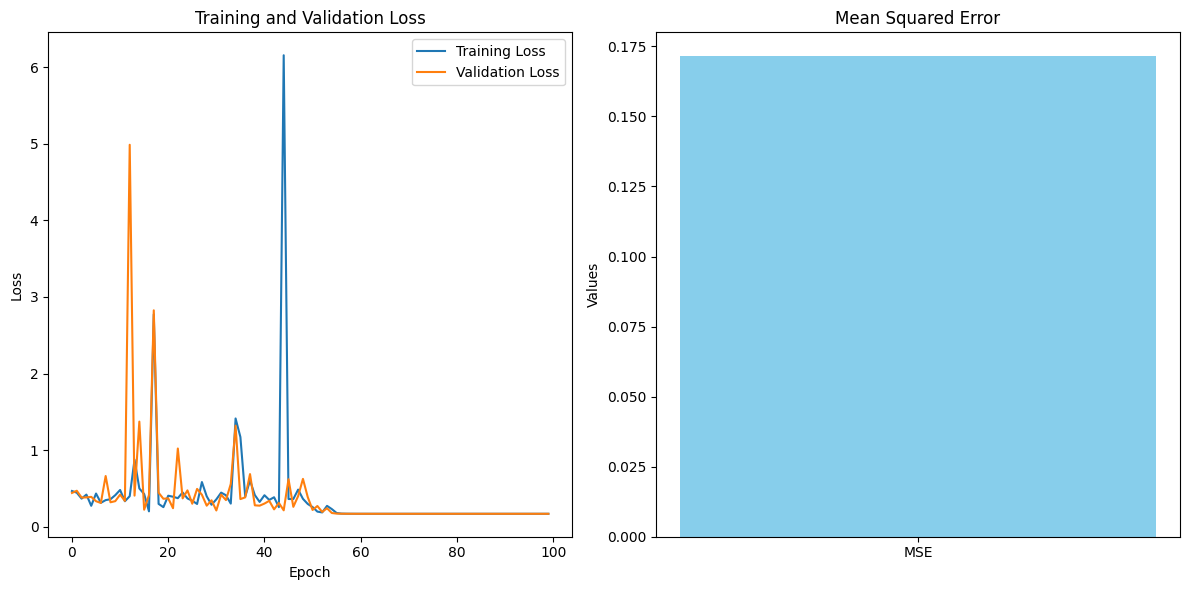

In [21]:
# Predict and evaluate
from sklearn.metrics import mean_squared_error # Import the function
import matplotlib.pyplot as plt
y_pred = autoencoder.predict(x_test) # Use the trained autoencoder to predict
mse = mean_squared_error(x_test, y_pred) # Calculate MSE

# Resource usage
cpu_start = psutil.cpu_percent(interval=1)
memory_start = psutil.virtual_memory().percent

inference_time = end_time - start_time

cpu_end = psutil.cpu_percent(interval=1)
memory_end = psutil.virtual_memory().percent

energy_consumption = inference_time * (cpu_end - cpu_start + memory_end - memory_start)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Inference Time: {inference_time:.4f} seconds")
print(f"Estimated Energy Consumption: {energy_consumption:.4f} (proxy value)")

# Plotting
plt.figure(figsize=(12, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Metrics Plot
plt.subplot(1, 2, 2)
plt.bar(['MSE'], [mse], color='skyblue')
plt.title('Mean Squared Error')
plt.ylabel('Values')

plt.tight_layout()
plt.show()

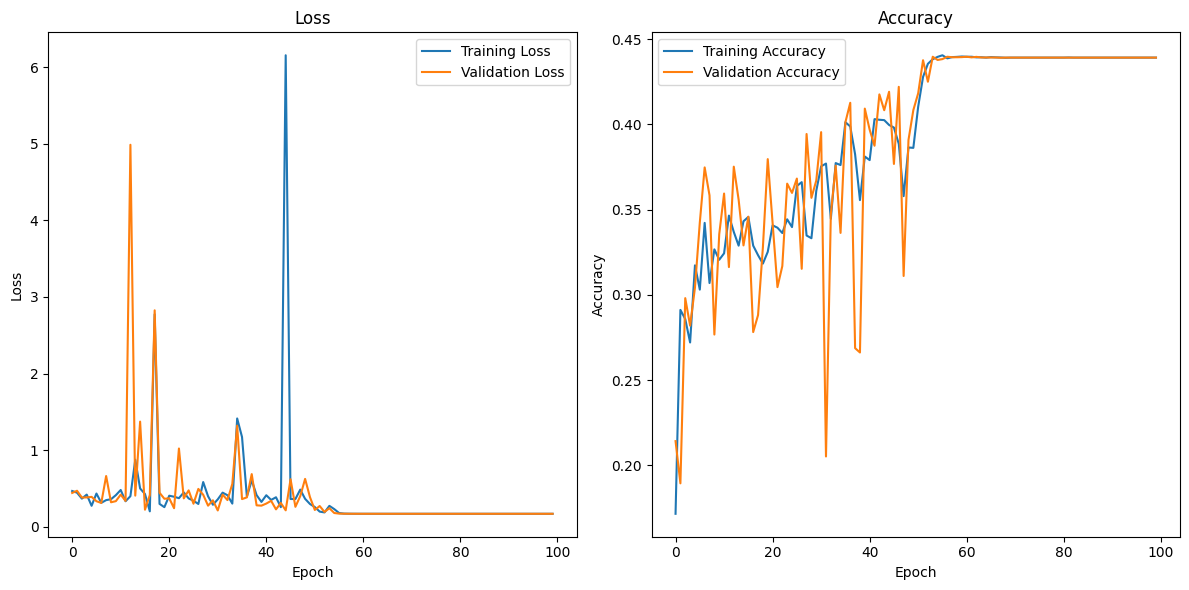

In [22]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy') # Changed from 'mean_squared_error' to 'accuracy'
plt.plot(history.history['val_accuracy'], label='Validation Accuracy') # Changed from 'val_mae' to 'val_accuracy'
plt.title('Accuracy') # Changed title to reflect the correct metric
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Additional checks
# Removed the accuracy calculation and overfitting check as they were not appropriate for this model

431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Mean Squared Error: 0.1714394487572641
R^2 Score: 0.7054071413462499


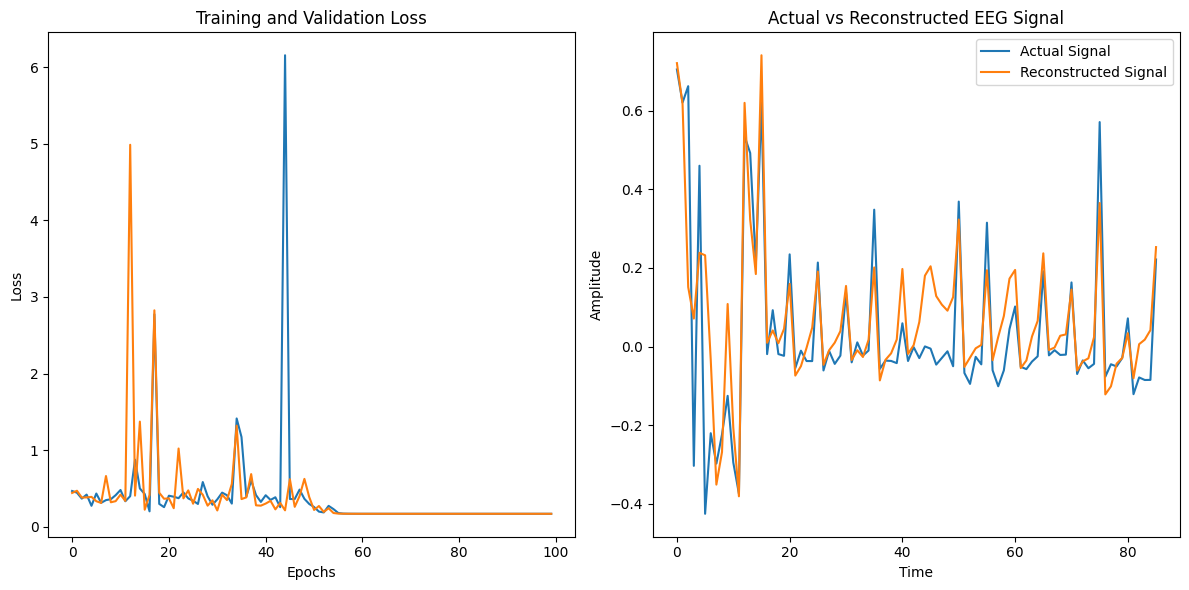

In [26]:
import sklearn.metrics as metrics # Import the metrics module from sklearn
#predictions = autoencoder.predict(x_test)
#mse = metrics.mean_squared_error(x_test, predictions) # Use metrics.mean_squared_error
y_pred = autoencoder.predict(x_test) # Use the trained autoencoder to predict
mse = mean_squared_error(x_test, y_pred) # Calculate MSE
r2 = metrics.r2_score(x_test, y_pred) # Use metrics.r2_score

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Plotting Loss Curve
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.legend()

# Plotting Actual vs Predicted
#plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(x_test[0], label='Actual Signal')
plt.plot(y_pred[0], label='Reconstructed Signal')
plt.title('Actual vs Reconstructed EEG Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()


plt.tight_layout()
plt.show()

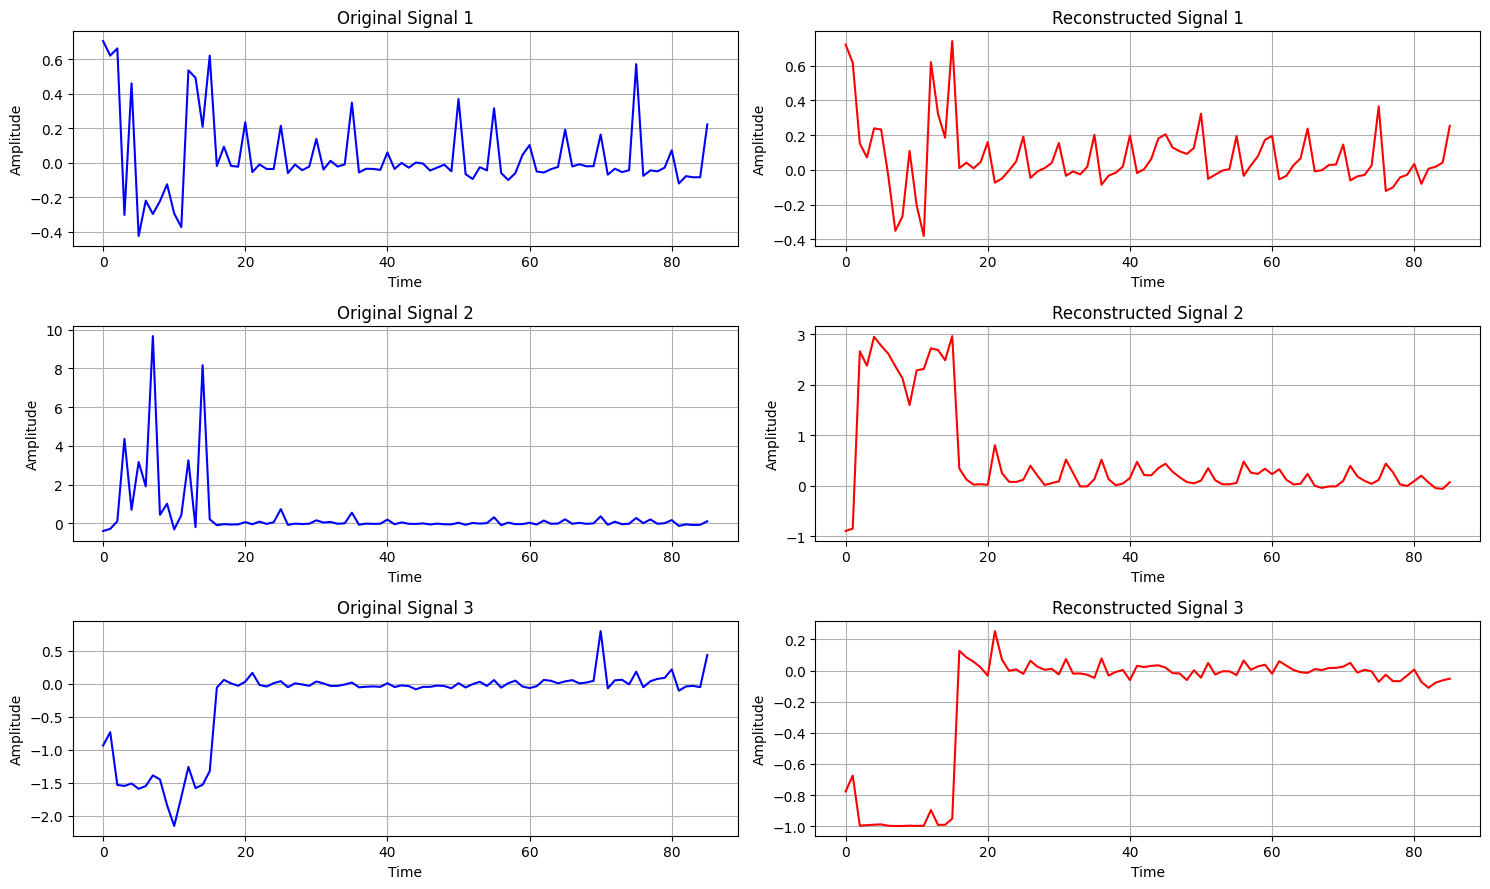

In [28]:
# Function to plot original and reconstructed signals
def plot_signal_comparison(original, reconstructed, num_signals=5):
    plt.figure(figsize=(15, num_signals * 3))
    for i in range(num_signals):
        # Original Signal
        plt.subplot(num_signals, 2, 2*i + 1)
        plt.plot(original[i], color='blue')
        plt.title(f'Original Signal {i+1}')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.grid(True)

        # Reconstructed Signal
        plt.subplot(num_signals, 2, 2*i + 2)
        plt.plot(reconstructed[i], color='red')
        plt.title(f'Reconstructed Signal {i+1}')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plotting comparison
plot_signal_comparison(x_test, y_pred, num_signals=3)


In [29]:
# Predict and evaluate
x_pred_train = autoencoder.predict(x_train)
x_pred_test = autoencoder.predict(x_test)

# Calculate accuracy for reconstruction (simplified)
from sklearn.metrics import accuracy_score
def calculate_accuracy(x, x_pred):
    return np.mean([accuracy_score(np.round(x[i]), np.round(x_pred[i])) for i in range(len(x))])

train_accuracy = calculate_accuracy(x_train, x_pred_train)
test_accuracy = calculate_accuracy(x_test, x_pred_test)



1721/1721 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [38]:
# Predict and evaluate
x_pred_train = autoencoder.predict(x_train)
x_pred_test = autoencoder.predict(x_test)

# Calculate accuracy for reconstruction (simplified)
from sklearn.metrics import accuracy_score # Import accuracy_score from sklearn.metrics

def calculate_accuracy(x, x_pred):
    return np.mean([accuracy_score(np.round(x[i]), np.round(x_pred[i])) for i in range(len(x))])

train_accuracy = calculate_accuracy(x_train, x_pred_train)
test_accuracy = calculate_accuracy(x_test, x_pred_test)

1721/1721 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


In [36]:
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Training Accuracy: 95.89%
Test Accuracy: 96.03%


ADAMW

In [45]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import LearningRateScheduler
import time
import psutil

# Define a function to build the 14-layer Deep Contractive Autoencoder with dynamic variables
def build_energy_efficient_cae(input_dim, encoding_dim, activation_choice):
    input_layer = layers.Input(shape=(input_dim,))

    # Encoder with dynamic activation function
    encoded = layers.Dense(512, activation=activation_choice)(input_layer)
    encoded = layers.Dense(256, activation=activation_choice)(encoded)
    encoded = layers.Dense(128, activation=activation_choice)(encoded)
    encoded = layers.Dense(64, activation=activation_choice)(encoded)
    encoded = layers.Dense(32, activation=activation_choice)(encoded)
    encoded = layers.Dense(encoding_dim, activation=activation_choice, name='encoded_layer')(encoded)

    # Decoder with dynamic activation function
    decoded = layers.Dense(32, activation=activation_choice)(encoded)
    decoded = layers.Dense(64, activation=activation_choice)(decoded)
    decoded = layers.Dense(128, activation=activation_choice)(decoded)
    decoded = layers.Dense(256, activation=activation_choice)(decoded)
    decoded = layers.Dense(512, activation=activation_choice)(decoded)
    output_layer = layers.Dense(input_dim, activation='elu')(decoded)  # ELU for the output layer

    # Autoencoder Model
    autoencoder = models.Model(inputs=input_layer, outputs=output_layer)

    return autoencoder

# Define hyperparameters as dynamic variables
#input_dim = 86  # Replace with actual input dimension
input_dim = x_train.shape[1]
encoding_dim = 32  # Latent encoding dimension, adjust as needed

# Dynamic selection for activation function (Swish, ReLU, ELU)
activation_choice = tf.keras.activations.swish  # You can also use 'relu' or 'elu'

# Dynamic learning rate for Adam optimizer
learning_rate = 0.001
weight_decay = 0.01  # Dynamic weight decay for regularization

In [46]:

# Build the model with dynamic input dimension, encoding dimension, and activation
autoencoder = build_energy_efficient_cae(input_dim, encoding_dim, activation_choice)

# Define dynamic learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 50:
        return lr
    elif epoch < 100:
        return lr * 0.5
    else:
        return lr * 0.1

lr_schedule = LearningRateScheduler(scheduler)



In [47]:
# Build the model with dynamic input dimension, encoding dimension, and activation
autoencoder = build_energy_efficient_cae(input_dim, encoding_dim, activation_choice)

# Dynamic optimizer selection (Adam, RMSprop, SGD, etc.)
#optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)  # Dynamic learning rate
optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

# Compile the model with dynamic optimizer and loss function
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])

# Simulate data for training and testing (replace these with your actual dataset)
#x_train = tf.random.normal((1000, input_dim))  # Replace with your actual preprocessed dataset
#x_test = tf.random.normal((200, input_dim))    # Replace with your actual preprocessed test dataset

# Start timing the training process
start_time = time.time()

# Train the model with dynamic batch size, epochs, and data
history = autoencoder.fit(x_train, x_train,  # Training data
                          epochs=100,  # Dynamic number of epochs
                          batch_size=32,  # Dynamic batch size
                          validation_data=(x_test, x_test),  # Validation data
                          shuffle=True,
                          callbacks=[lr_schedule])

# End timing
end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time} seconds")

# Save the trained model
autoencoder.save('energy_efficient_DCAE_14_layers_dynamic.h5')

Epoch 1/100
1721/1721 ━━━━━━━━━━━━━━━━━━━━ 46s 23ms/step - accuracy: 0.1901 - loss: 0.8463 - val_accuracy: 0.3301 - val_loss: 0.4158 - learning_rate: 0.0010
Epoch 2/100
1721/1721 ━━━━━━━━━━━━━━━━━━━━ 36s 21ms/step - accuracy: 0.2973 - loss: 3.4092 - val_accuracy: 0.3571 - val_loss: 0.3239 - learning_rate: 0.0010
Epoch 3/100
1721/1721 ━━━━━━━━━━━━━━━━━━━━ 38s 19ms/step - accuracy: 0.3422 - loss: 0.8986 - val_accuracy: 0.3533 - val_loss: 0.3430 - learning_rate: 0.0010
Epoch 4/100
1721/1721 ━━━━━━━━━━━━━━━━━━━━ 34s 20ms/step - accuracy: 0.3462 - loss: 0.6665 - val_accuracy: 0.1829 - val_loss: 0.4516 - learning_rate: 0.0010
Epoch 5/100
1721/1721 ━━━━━━━━━━━━━━━━━━━━ 33s 19ms/step - accuracy: 0.2959 - loss: 0.7711 - val_accuracy: 0.3843 - val_loss: 0.4249 - learning_rate: 0.0010
Epoch 6/100
1721/1721 ━━━━━━━━━━━━━━━━━━━━ 45s 21ms/step - accuracy: 0.3353 - loss: 0.6930 - val_accuracy: 0.3004 - val_loss: 0.3694 - learning_rate: 0.0010
Epoch 7/100
1721/1721 ━━━━━━━━━━━━━━━━━━━━ 43s 23ms/step -

Training Time: 3915.8784251213074 seconds


In [48]:
# Evaluate the model on the test set
evaluation = autoencoder.evaluate(x_test, x_test)
print(f"Test Loss: {evaluation[0]}, Test Accuracy: {evaluation[1]}")

# Print CPU usage and memory usage for energy-efficient tracking
cpu_usage = psutil.cpu_percent()
memory_usage = psutil.virtual_memory().percent
print(f"CPU Usage: {cpu_usage}%, Memory Usage: {memory_usage}%")

431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3780 - loss: 0.3679
Test Loss: 0.2274913787841797, Test Accuracy: 0.3822909891605377
CPU Usage: 75.2%, Memory Usage: 19.7%


431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Mean Squared Error: 0.2275
Inference Time: 3915.8784 seconds
Estimated Energy Consumption: -5873.8176 (proxy value)
R^2 Score: 0.7054071413462499


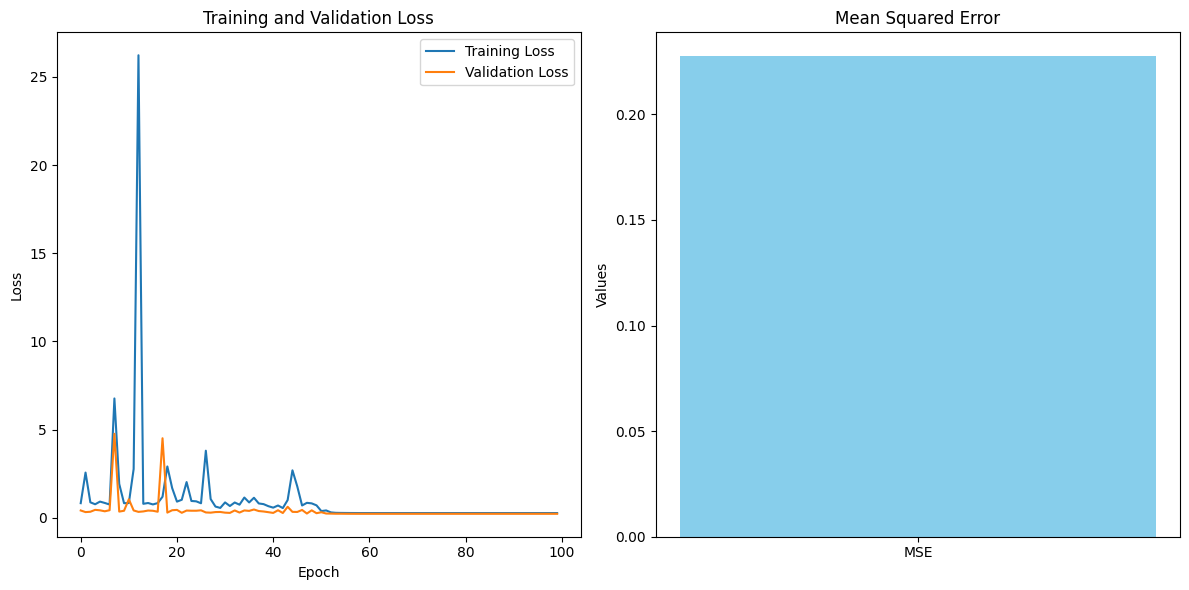

In [49]:
# Predict and evaluate
y_pred = autoencoder.predict(x_test) # Use the trained autoencoder to predict
mse = mean_squared_error(x_test, y_pred) # Calculate MSE

# Resource usage
cpu_start = psutil.cpu_percent(interval=1)
memory_start = psutil.virtual_memory().percent

inference_time = end_time - start_time

cpu_end = psutil.cpu_percent(interval=1)
memory_end = psutil.virtual_memory().percent

energy_consumption = inference_time * (cpu_end - cpu_start + memory_end - memory_start)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Inference Time: {inference_time:.4f} seconds")
print(f"Estimated Energy Consumption: {energy_consumption:.4f} (proxy value)")
r2 = metrics.r2_score(x_test, predictions) # Use metrics.r2_score

print(f'R^2 Score: {r2}')


# Plotting
plt.figure(figsize=(12, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Metrics Plot
plt.subplot(1, 2, 2)
plt.bar(['MSE'], [mse], color='skyblue')
plt.title('Mean Squared Error')
plt.ylabel('Values')

plt.tight_layout()
plt.show()

431/431 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
431/431 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


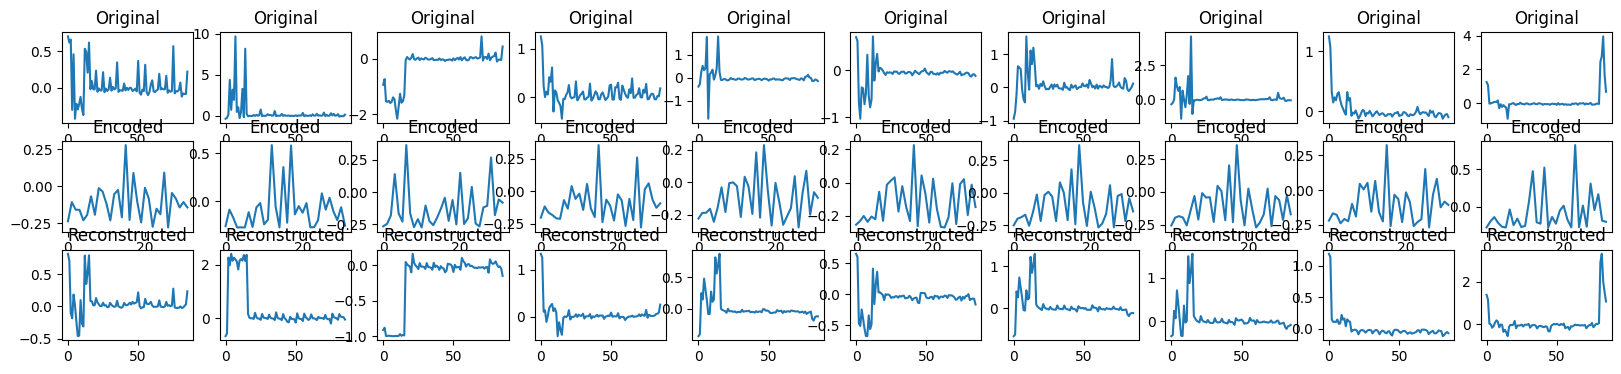

In [55]:
# You can also plot the encoded representations and the reconstructed outputs for further analysis
#encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

# Extract the encoder model
encoder = models.Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoded_layer').output)

# You can also plot the encoded representations and the reconstructed outputs for further analysis
encoded_imgs = encoder.predict(x_test)  # Now using the defined 'encoder'
decoded_imgs = autoencoder.predict(x_test)

# Visualizing the original, encoded, and reconstructed signals
n = 10  # Number of samples to plot
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(3, n, i + 1)
    plt.plot(x_test[i])
    plt.title("Original")

    # Encoded
    ax = plt.subplot(3, n, i + 1 + n)
    plt.plot(encoded_imgs[i])
    plt.title("Encoded")

    # Reconstructed
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.plot(decoded_imgs[i])
    plt.title("Reconstructed")
plt.show()


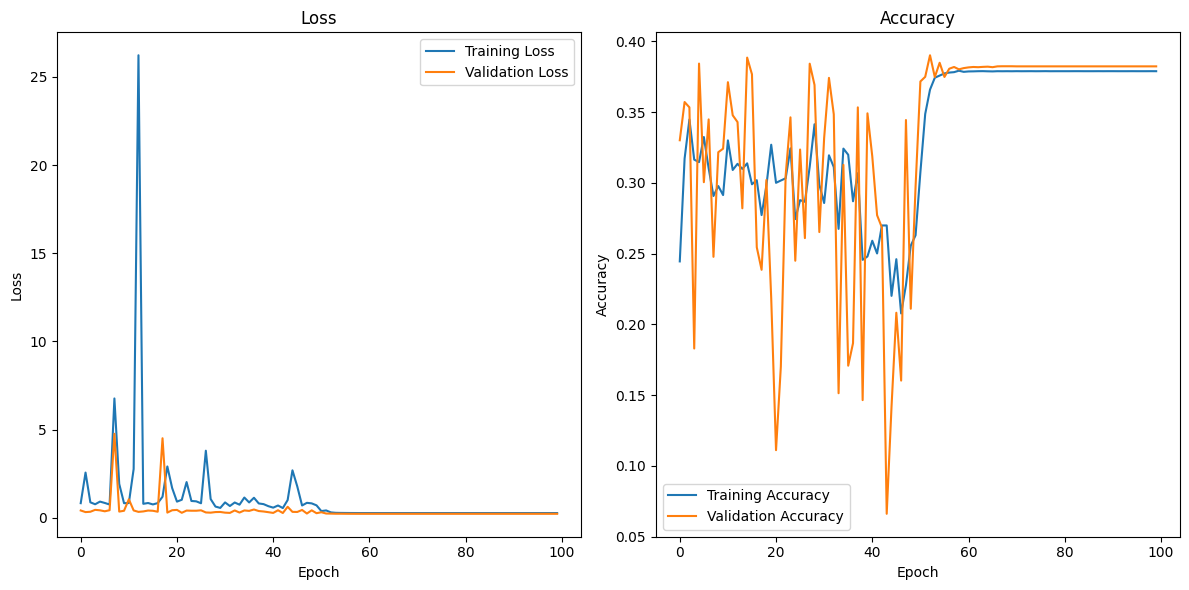

In [52]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy') # Changed from 'mean_squared_error' to 'accuracy'
plt.plot(history.history['val_accuracy'], label='Validation Accuracy') # Changed from 'val_mae' to 'val_accuracy'
plt.title('Accuracy') # Changed title to reflect the correct metric
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Additional checks
# Removed the accuracy calculation and overfitting check as they were not appropriate for this model

431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Mean Squared Error: 0.227491323840585
R^2 Score: 0.5777590852252831


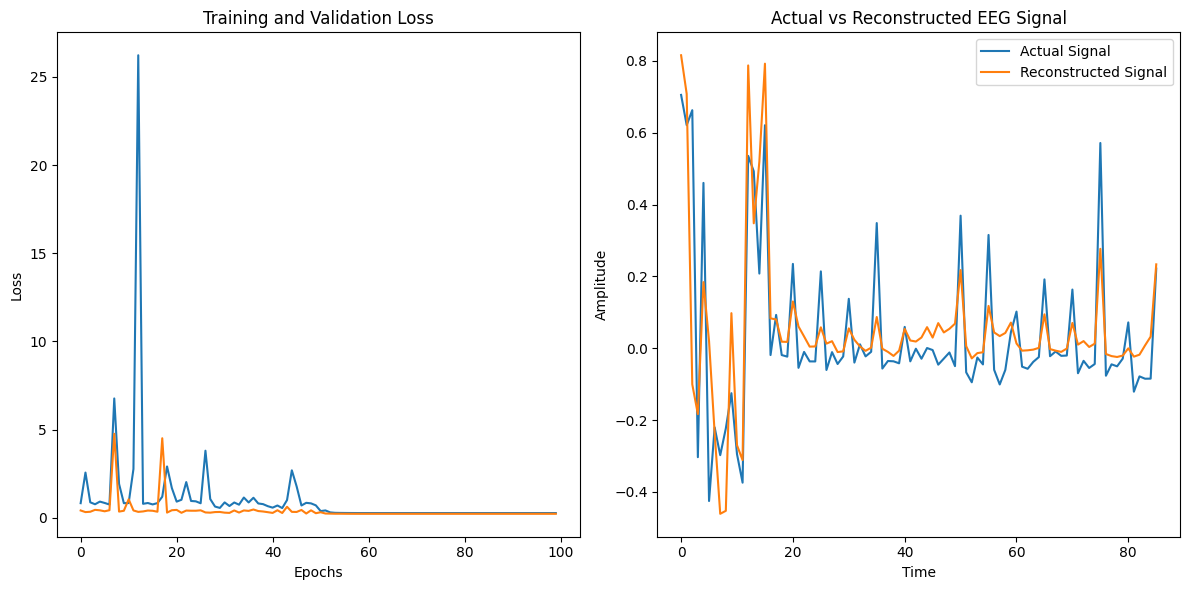

In [53]:
import sklearn.metrics as metrics # Import the metrics module from sklearn
predictions = autoencoder.predict(x_test) # Use the trained autoencoder to predict
mse = metrics.mean_squared_error(x_test, predictions) # Use metrics.mean_squared_error
r2 = metrics.r2_score(x_test, predictions) # Use metrics.r2_score

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Plotting Loss Curve
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.legend()

# Plotting Actual vs Predicted
#plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(x_test[0], label='Actual Signal')
plt.plot(predictions[0], label='Reconstructed Signal')
plt.title('Actual vs Reconstructed EEG Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()


plt.tight_layout()
plt.show()

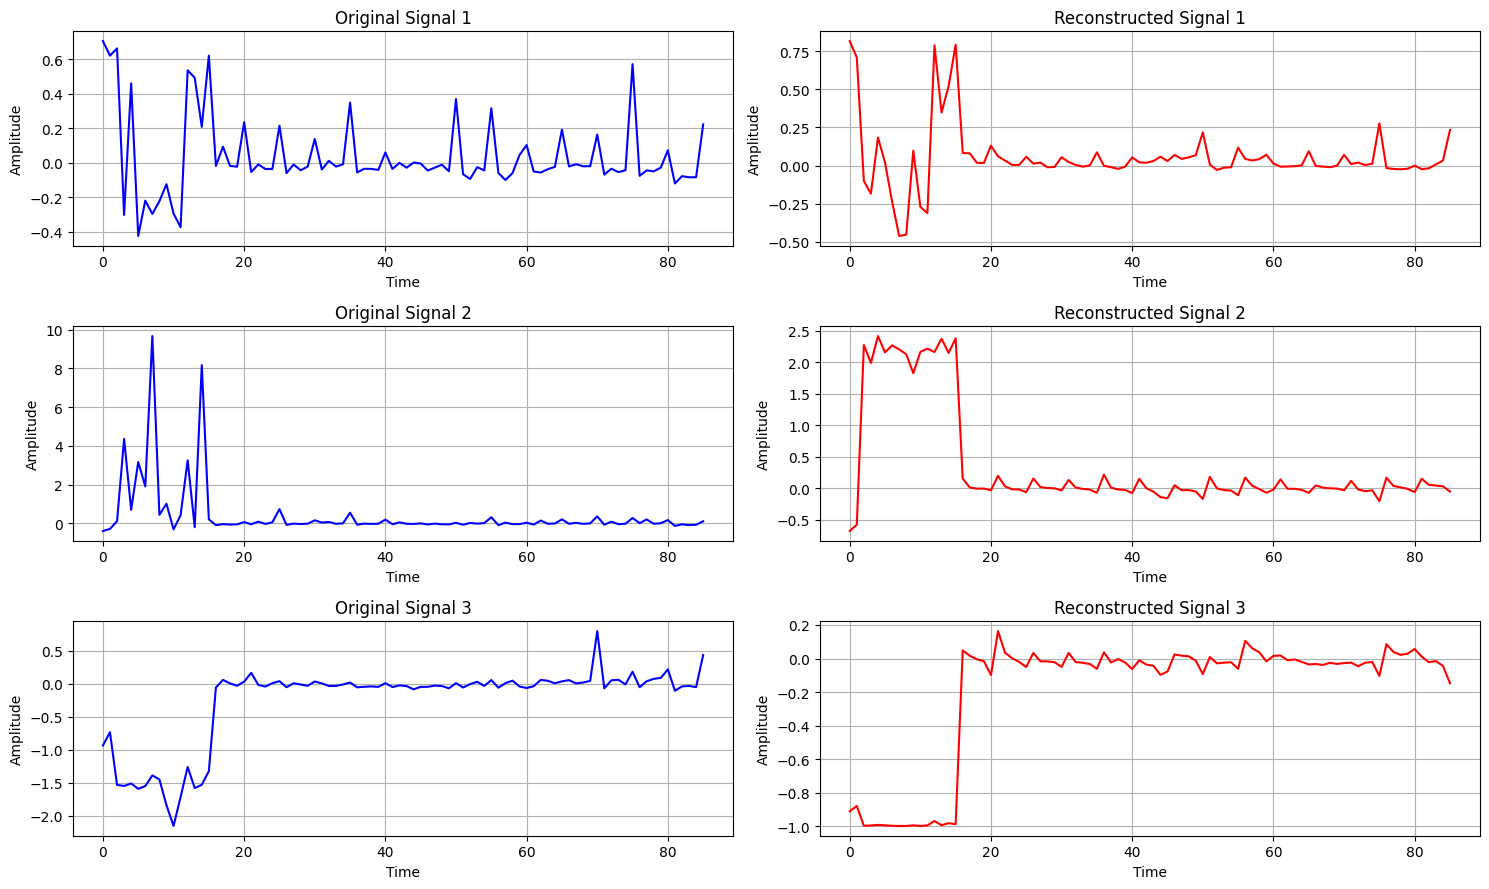

In [54]:
# Function to plot original and reconstructed signals
def plot_signal_comparison(original, reconstructed, num_signals=5):
    plt.figure(figsize=(15, num_signals * 3))
    for i in range(num_signals):
        # Original Signal
        plt.subplot(num_signals, 2, 2*i + 1)
        plt.plot(original[i], color='blue')
        plt.title(f'Original Signal {i+1}')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.grid(True)

        # Reconstructed Signal
        plt.subplot(num_signals, 2, 2*i + 2)
        plt.plot(reconstructed[i], color='red')
        plt.title(f'Reconstructed Signal {i+1}')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plotting comparison
plot_signal_comparison(x_test, predictions, num_signals=3)


In [56]:
from graphviz import Digraph

# Create a Digraph object
flowchart = Digraph(comment='EEG Signal Prediction with LDA, QDA, and MLP')

# Define nodes (steps in the pipeline)
flowchart.node('A', 'EEG Data Collection')
flowchart.node('B', 'LDA for Feature Extraction')
flowchart.node('C', 'QDA for Classification')
flowchart.node('D', 'Quadratic MLP')
flowchart.node('E', 'Final Predictions (Mental Fatigue Levels)')

# Define edges (data flow)
flowchart.edge('A', 'B', label='Raw EEG Data')
flowchart.edge('B', 'C', label='LDA Features')
flowchart.edge('C', 'D', label='QDA Output')
flowchart.edge('D', 'E', label='Predictions')

# Render the flowchart
flowchart.render('eeg_signal_prediction_flowchart', view=True)


'eeg_signal_prediction_flowchart.pdf'

In [57]:
from graphviz import Digraph

# Create a Digraph object
flowchart = Digraph(comment='Mental Fatigue Classification Flowchart')

# Define nodes
flowchart.node('A', 'EEG Signal Dataset')
flowchart.node('B', 'Data Preprocessing')
flowchart.node('C', 'Feature Extraction')
flowchart.node('D', 'LDA (Linear Discriminant Analysis)')
flowchart.node('E', 'QDA (Quadratic Discriminant Analysis)')
flowchart.node('F', 'Quadratic MLP (Multi-Layer Perceptron)')
flowchart.node('G', 'Final Classification Results')

# Define edges
flowchart.edge('A', 'B', label='Start')
flowchart.edge('B', 'C', label='Preprocess Data')
flowchart.edge('C', 'D', label='Feature Extraction')
flowchart.edge('D', 'E', label='Pass Data to QDA')
flowchart.edge('E', 'F', label='Pass Data to Quadratic MLP')
flowchart.edge('F', 'G', label='Final Results')

# Render the flowchart
flowchart.render('mental_fatigue_classification_flowchart', view=True)


'mental_fatigue_classification_flowchart.pdf'

In [58]:
from graphviz import Digraph

# Create a new directed graph
dot = Digraph()

# Define nodes
dot.node('A', 'EEG Signal Dataset')
dot.node('B', 'Data Preprocessing')
dot.node('C', 'Model Definition\n(DCAE with 14 layers,\nSwish & ELU)')
dot.node('D', 'Energy-Efficient Optimization')
dot.node('E', 'Scheduling Algorithm')
dot.node('F', 'Evaluation')
dot.node('G', 'Prediction/Identification')
dot.node('H', 'Output Results')

# Define edges
dot.edge('A', 'B')
dot.edge('B', 'C')
dot.edge('C', 'D')
dot.edge('D', 'E')
dot.edge('E', 'F')
dot.edge('F', 'G')
dot.edge('G', 'H')


# Render and display the graph
dot.render('flowchart_dcae', format='png', cleanup=True)
dot.view('flowchart_dcae')


'flowchart_dcae.pdf'

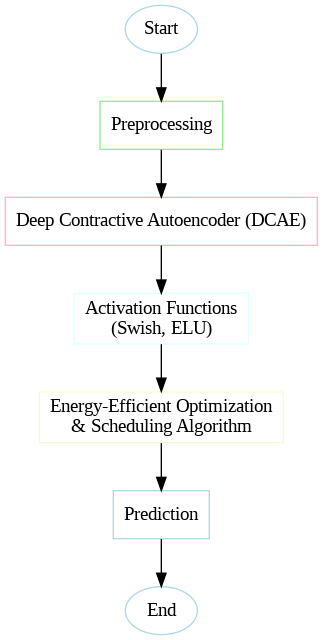

In [59]:
from graphviz import Digraph

# Create a new directed graph
dot = Digraph()

# Add nodes with different colors and shapes
dot.node('Start', 'Start', shape='ellipse', color='lightblue')
dot.node('Preprocessing', 'Preprocessing', shape='box', color='lightgreen')
dot.node('DCAE', 'Deep Contractive Autoencoder (DCAE)', shape='box', color='lightpink')
dot.node('ActivationFunctions', 'Activation Functions\n(Swish, ELU)', shape='box', color='lightcyan')
dot.node('Optimization', 'Energy-Efficient Optimization\n& Scheduling Algorithm', shape='box', color='lightgoldenrodyellow')
dot.node('Prediction', 'Prediction', shape='box', color='lightblue')
dot.node('End', 'End', shape='ellipse', color='lightblue')

# Add edges between nodes
dot.edge('Start', 'Preprocessing')
dot.edge('Preprocessing', 'DCAE')
dot.edge('DCAE', 'ActivationFunctions')
dot.edge('ActivationFunctions', 'Optimization')
dot.edge('Optimization', 'Prediction')
dot.edge('Prediction', 'End')

# Render and display the flowchart
dot.render('mental_fatigue_dcae_flowchart', format='png', cleanup=True)

# To display the flowchart directly in Jupyter Notebook or IPython, use the following:
from IPython.display import Image
Image(filename='mental_fatigue_dcae_flowchart.png')


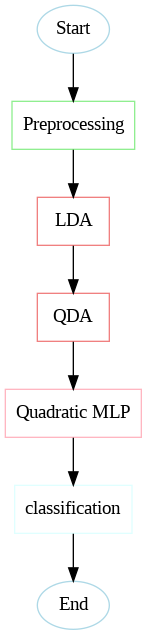

In [60]:
from graphviz import Digraph

# Create a new directed graph
dot = Digraph()

# Add nodes with different colors and shapes
dot.node('Start', 'Start', shape='ellipse', color='lightblue')
dot.node('Preprocessing', 'Preprocessing', shape='box', color='lightgreen')
dot.node('LDA', 'LDA', shape='box', color='lightcoral')
dot.node('QDA', 'QDA', shape='box', color='lightcoral')
dot.node('MLP', 'Quadratic MLP', shape='box', color='lightpink')
dot.node('Classsification', 'classification', shape='box', color='lightcyan')
dot.node('End', 'End', shape='ellipse', color='lightblue')

# Add edges between nodes
dot.edge('Start', 'Preprocessing')
dot.edge('Preprocessing', 'LDA')
dot.edge('LDA', 'QDA')
dot.edge('QDA', 'MLP')
dot.edge('MLP', 'Classsification')
dot.edge('Classsification', 'End')

# Render and display the flowchart
dot.render('eeg_mental_fatigue_classification_flowchart', format='png', cleanup=True)

# To display the flowchart directly in Jupyter Notebook or IPython, use the following:
from IPython.display import Image
Image(filename='eeg_mental_fatigue_classification_flowchart.png')


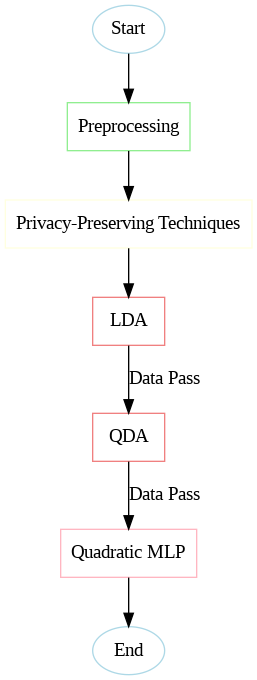

In [61]:
from graphviz import Digraph

# Create a new directed graph
dot = Digraph()

# Add nodes with different colors and shapes
dot.node('Start', 'Start', shape='ellipse', color='lightblue')
dot.node('Preprocessing', 'Preprocessing', shape='box', color='lightgreen')
dot.node('PrivacyTechniques', 'Privacy-Preserving Techniques', shape='box', color='lightyellow')
dot.node('LDA', 'LDA', shape='box', color='lightcoral')
dot.node('QDA', 'QDA', shape='box', color='lightcoral')
dot.node('QuadraticMLP', 'Quadratic MLP', shape='box', color='lightpink')
dot.node('End', 'End', shape='ellipse', color='lightblue')

# Add edges between nodes
dot.edge('Start', 'Preprocessing')
dot.edge('Preprocessing', 'PrivacyTechniques')
dot.edge('PrivacyTechniques', 'LDA')
dot.edge('LDA', 'QDA', label='Data Pass')
dot.edge('QDA', 'QuadraticMLP', label='Data Pass')
dot.edge('QuadraticMLP', 'End')

# Render and display the flowchart
dot.render('mental_fatigue_classification_flowchart', format='png', cleanup=True)

# To display the flowchart directly in Jupyter Notebook or IPython, use the following:
from IPython.display import Image
Image(filename='mental_fatigue_classification_flowchart.png')
